In [3]:
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING) 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from fbprophet import Prophet
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.linear_model import LinearRegression

orders_df = pd.read_csv("orders.csv")
partners_delays_df = pd.read_csv("partners_delays.csv")
partners_delays_df = partners_delays_df.rename(columns={"delivery_area_id": "delivery_area_id", "dttm": "date", "partners_cnt": "partners_cnt", "delay_rate": "delay_rate"})
new_df = pd.merge(orders_df, partners_delays_df,  how='inner', on=['delivery_area_id','date'])
cal = calendar()
dr = pd.date_range(start='2021-04-01', end='2021-11-30')
holidays = cal.holidays(start=dr.min(), end=dr.max())

new_df['Holiday'] = new_df['date'].isin(holidays)
new_df["date"] = pd.to_datetime(new_df["date"])
new_df['datehour'] = new_df['date'].dt.hour
new_df['time'] = [d.time() for d in new_df['date']]

new_df = new_df[["delivery_area_id", "date", 'Holiday', 'datehour', "orders_cnt", "partners_cnt", "delay_rate"]]

new_df["date"] = pd.to_datetime(new_df["date"])
new_df['day_of_week'] = new_df['date'].dt.day_name()
new_df = new_df[['delivery_area_id', 'date', 'day_of_week','Holiday', 'datehour', 'orders_cnt', 'partners_cnt', 'delay_rate']]
new_df.tail(100)

Importing plotly failed. Interactive plots will not work.


,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate
884756,592,2021-11-22 13:00:00,Monday,False,13,3,3.0,0.0
884757,592,2021-11-22 14:00:00,Monday,False,14,3,2.0,0.0
884758,592,2021-11-22 15:00:00,Monday,False,15,8,3.0,0.0
884759,592,2021-11-22 16:00:00,Monday,False,16,4,2.0,0.0
884760,592,2021-11-22 17:00:00,Monday,False,17,2,2.0,0.0
...,...,...,...,...,...,...,...,...
884851,592,2021-11-30 16:00:00,Tuesday,False,16,6,3.0,0.0
884852,592,2021-11-30 17:00:00,Tuesday,False,17,3,2.0,0.0
884853,592,2021-11-30 18:00:00,Tuesday,False,18,2,2.0,0.0
884854,592,2021-11-30 19:00:00,Tuesday,False,19,4,2.0,0.0


In [6]:
predictions = 3
# приводим dataframe к нужному формату
df = new_df
df = df.where(df['delivery_area_id']== 1)
df = df.where(df['day_of_week'] == "Monday")
df = df.where(df['datehour'] == 9)
#df = df.where(df['Holiday'] == False)
df = df.drop(columns= ['day_of_week', 'datehour', 'partners_cnt', 'delay_rate'], axis = 1)
df = df.drop(columns= ['delivery_area_id'], axis = 1)
df = df.rename(columns= {"date": "ds", "orders_cnt": "y"})
df = df.dropna()
# отрезаем из обучающей выборки последние 30 точек, чтобы измерить на них качество
train_df = df[:-predictions] 
df.head(100)
df.isna().value_counts()

ds     Holiday  y    
False  False    False    10
dtype: int64

In [3]:
m = Prophet()
m.fit(train_df)

17:51:01 - cmdstanpy - INFO - Chain [1] start processing
17:51:01 - cmdstanpy - INFO - Chain [1] done processing


In [4]:
future = m.make_future_dataframe(periods=predictions)
forecast = m.predict(future)

In [5]:
new_df.dtypes
new_df['datehour'] = new_df['date'].dt.hour

In [6]:
new_df.head()

,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate
0,0,2021-04-01 10:00:00,Thursday,False,10,9,4.0,0.111111
1,0,2021-04-01 11:00:00,Thursday,False,11,1,4.0,0.000000
2,0,2021-04-01 13:00:00,Thursday,False,13,1,1.0,0.000000
3,0,2021-04-01 14:00:00,Thursday,False,14,1,1.0,0.000000
4,0,2021-04-01 15:00:00,Thursday,False,15,2,1.0,0.000000


In [7]:
cal = calendar()
dr = pd.date_range(start='2021-04-01', end='2021-11-30')
holidays = cal.holidays(start=dr.min(), end=dr.max())

new_df['Holiday'] = new_df['date'].isin(holidays)*1
new_df.head()

,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate
0,0,2021-04-01 10:00:00,Thursday,0,10,9,4.0,0.111111
1,0,2021-04-01 11:00:00,Thursday,0,11,1,4.0,0.000000
2,0,2021-04-01 13:00:00,Thursday,0,13,1,1.0,0.000000
3,0,2021-04-01 14:00:00,Thursday,0,14,1,1.0,0.000000
4,0,2021-04-01 15:00:00,Thursday,0,15,2,1.0,0.000000


In [8]:
new_df['cnt'] = new_df['partners_cnt'] / new_df['orders_cnt']


In [9]:
new_df.head()

,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate,cnt
0,0,2021-04-01 10:00:00,Thursday,0,10,9,4.0,0.111111,0.444444
1,0,2021-04-01 11:00:00,Thursday,0,11,1,4.0,0.000000,4.000000
2,0,2021-04-01 13:00:00,Thursday,0,13,1,1.0,0.000000,1.000000
3,0,2021-04-01 14:00:00,Thursday,0,14,1,1.0,0.000000,1.000000
4,0,2021-04-01 15:00:00,Thursday,0,15,2,1.0,0.000000,0.500000


In [10]:
new_df = new_df.drop(new_df[new_df['delay_rate'] ==1].index)
new_df

,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate,cnt
0,0,2021-04-01 10:00:00,Thursday,0,10,9,4.0,0.111111,0.444444
1,0,2021-04-01 11:00:00,Thursday,0,11,1,4.0,0.000000,4.000000
2,0,2021-04-01 13:00:00,Thursday,0,13,1,1.0,0.000000,1.000000
3,0,2021-04-01 14:00:00,Thursday,0,14,1,1.0,0.000000,1.000000
4,0,2021-04-01 15:00:00,Thursday,0,15,2,1.0,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
884851,592,2021-11-30 16:00:00,Tuesday,0,16,6,3.0,0.000000,0.500000
884852,592,2021-11-30 17:00:00,Tuesday,0,17,3,2.0,0.000000,0.666667
884853,592,2021-11-30 18:00:00,Tuesday,0,18,2,2.0,0.000000,1.000000
884854,592,2021-11-30 19:00:00,Tuesday,0,19,4,2.0,0.000000,0.500000


In [11]:
df_copy = new_df.copy()

In [12]:
df_copy = df_copy[df_copy['delivery_area_id'] == 0]
df_copy

,delivery_area_id,date,day_of_week,Holiday,datehour,orders_cnt,partners_cnt,delay_rate,cnt
0,0,2021-04-01 10:00:00,Thursday,0,10,9,4.0,0.111111,0.444444
1,0,2021-04-01 11:00:00,Thursday,0,11,1,4.0,0.000000,4.000000
2,0,2021-04-01 13:00:00,Thursday,0,13,1,1.0,0.000000,1.000000
3,0,2021-04-01 14:00:00,Thursday,0,14,1,1.0,0.000000,1.000000
4,0,2021-04-01 15:00:00,Thursday,0,15,2,1.0,0.000000,0.500000
...,...,...,...,...,...,...,...,...,...
2834,0,2021-11-30 17:00:00,Tuesday,0,17,10,6.0,0.200000,0.600000
2835,0,2021-11-30 18:00:00,Tuesday,0,18,21,8.0,0.190476,0.380952
2836,0,2021-11-30 19:00:00,Tuesday,0,19,10,6.0,0.000000,0.600000
2837,0,2021-11-30 20:00:00,Tuesday,0,20,15,6.0,0.066667,0.400000


Text(0, 0.5, 'delay_rate')

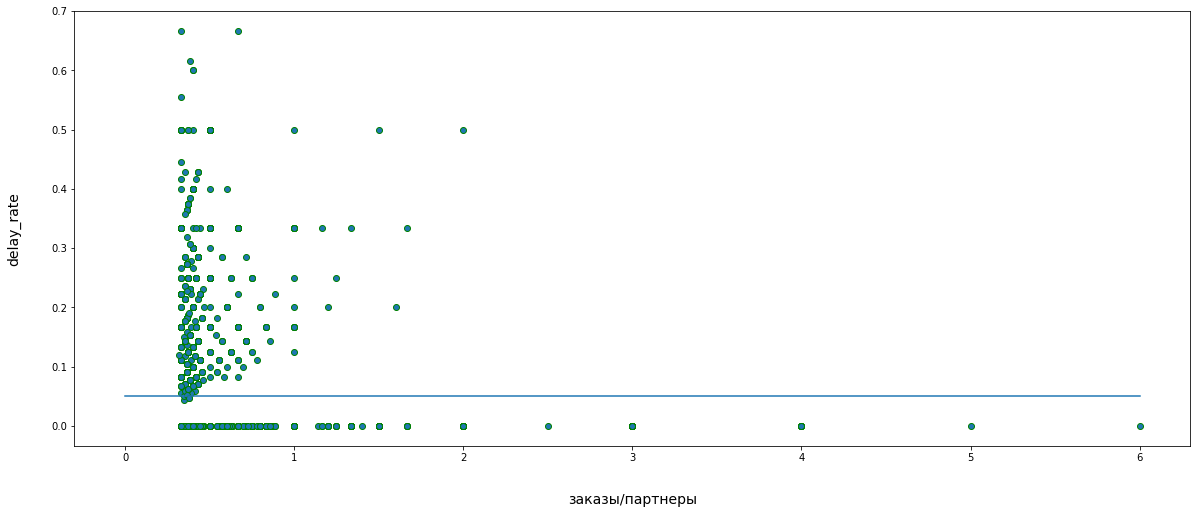

In [13]:
fig, ax = plt.subplots(figsize=(20, 8))
a = np.array([0.05] * 7)
ax.scatter(df_copy['cnt'].values, df_copy['delay_rate'].values, marker=None, cmap=None, vmin=None, alpha=None, linewidths=None, edgecolors='Green')
ax.plot(a)
ax.set_xlabel("заказы/партнеры", fontsize=14, labelpad=30)
ax.set_ylabel("delay_rate", fontsize=14, labelpad=30)

In [14]:
df_copy1 = new_df.copy()
df_copy1 = df_copy1[df_copy1['delivery_area_id'] == 2]

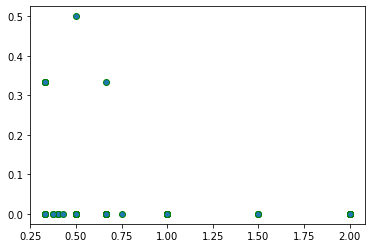

In [15]:
plt.scatter(df_copy1['cnt'].values, df_copy1['delay_rate'].values, marker=None, cmap=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors='Green') 

In [16]:
df_copy2 = new_df.copy()
df_copy2 = df_copy2[df_copy2['delivery_area_id'] == 3]

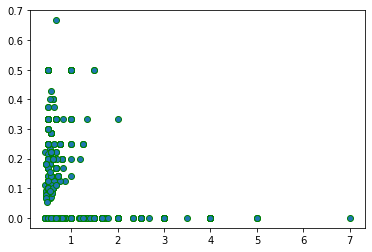

In [17]:
plt.scatter(df_copy2['cnt'].values, df_copy2['delay_rate'].values, marker=None, cmap=None, vmin=None, vmax=None, alpha=None, linewidths=None, edgecolors='Green') 

In [18]:
delivery_area_id = new_df['delivery_area_id'].tolist()
datehour = new_df['datehour'].tolist()
cnt = new_df['cnt'].tolist()
delay_rate = new_df['delay_rate'].tolist()
# partners_cnt = new_df['partners_cnt'].tolist()

In [19]:
d = {}

for i in range(0, len(cnt)):
    if delivery_area_id[i] not in d.keys():
        d[delivery_area_id[i]] = [[delay_rate[i]],[cnt[i]]]
    else:
        d[delivery_area_id[i]][0].append(delay_rate[i])
        d[delivery_area_id[i]][1].append(cnt[i])

In [21]:
result = []
c=0
for i in range(593):
    for j in sorted(d[i][1]):
        for k in range(len(d[i][0])):
            if d[i][1][k]>j and d[i][0][k]>0.05:
                c+=1
        if c/len(d[i][0]) <0.1:
                result.append(j)
                break
        c=0
    
result = list(result)

In [153]:
from scipy.optimize import linprog
import numpy as np
def plot_minimized_hours(my_data):
    # cminimizes spare hours
    A = np.zeros((11,30),dtype = int)
    j=0
    for length in range(4,9):
        for i in range(12-length):
            A[i:(i+length),j] = -1
            j += 1
    B = -1*A
    A = A.tolist()
    c = [1 for i in range(30)]
    #h = [-122, -117,- 89,-23,-28,-31,-56,-98,-112,-110]
    # h = [-1,-5,-3,-1,-2,-1,-3,-5,-6,-3,-1]
    h = []
    for i in range(0, len(my_data)):
        h.append(-my_data[i])
    # h = my_data
    res = linprog(c, A_ub=A, b_ub=h, method="revised simplex")
    number_cour = res.x
    my_ata_2 = np.dot(B,number_cour)

    # plots 2 histograms
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    plt.xlabel("Интервал Времени")
    x=["10.00", "11.00", "12.00", "13.00", "14.00", "15.00", "16.00", "17.00", "18.00", "19.00", "20.00"]

    xpos = np.arange(len(x))     
    plt.xticks(xpos, x)
    ax.bar(xpos-0.2, my_data, width=0.4, label="Входной прогноз")
    ax.bar(xpos+0.2, my_ata_2, width=0.4, label="Прогноз с поправкой на замощение")
    plt.legend()
    ax.grid()
    



In [147]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
preds = pd.DataFrame()
for j in range(1,594):
    for d in days:
        for i in range (10,21):
            df = new_df
            df = df.where(df['datehour'] == i)
            df = df.where(df['delivery_area_id']== j)
            df = df.where(df['day_of_week'] == d)
            df = df.where(df['Holiday'] == False)
            df = df.drop(columns= ['day_of_week', 'datehour', 'partners_cnt', 'delay_rate'], axis = 1)
            df = df.drop(columns= ['delivery_area_id', 'Holiday'], axis = 1)
            df = df.rename(columns= {"date": "ds", "orders_cnt": "y"})
            df = df.dropna()
            if len(df)<5:
                nr = {'delivery_area_id':f'{j}', 'day' : f'{d}', 'datehour' : f'{i}', 'orders': f'{0}' ,'partners': f'{0}'}
                #print(nr)
                preds = preds.append(nr, ignore_index = True)
            if len(df)>= 5:
                m = Prophet()
                m.fit(df)
                future = m.make_future_dataframe(periods=1)
                forecast = m.predict(future)
                #m.plot(forecast)
                e =max(forecast['yhat'].loc[forecast.index[0]], 0)
                q = forecast['yhat'].loc[forecast.index[0]]
                #print (q)
                nr = {'delivery_area_id':f'{j}', 'day' : f'{d}', 'datehour' : f'{i}', 'orders': f'{e}', 'partners' : f'{e*q}'}
                #print(nr)
                preds = preds.append(nr, ignore_index = True)
                
    #print ('MAPE', np.mean(abs(cmp_df[-predictions:]['p'])))
    #print ('MAE', np.mean(abs(cmp_df[-predictions:]['e'])))

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_s

KeyboardInterrupt: 

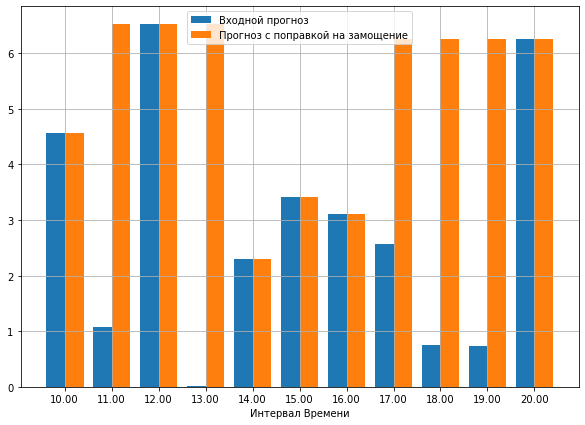

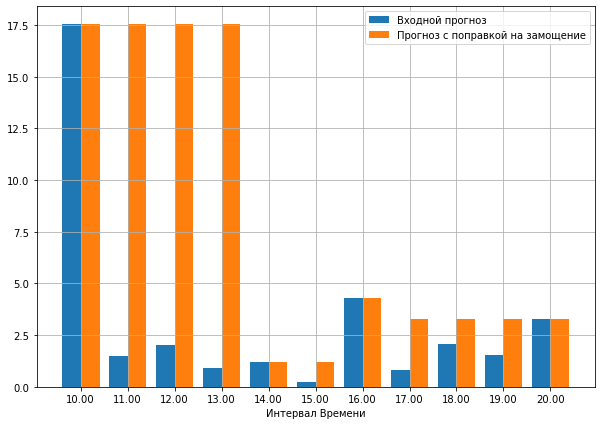

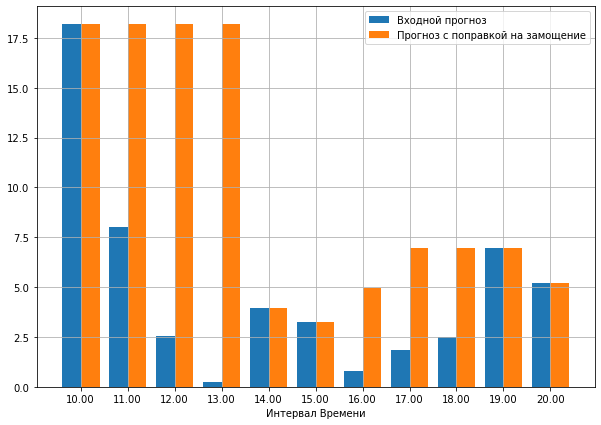

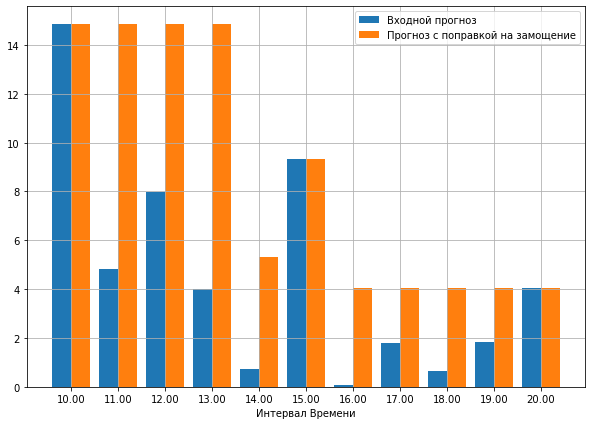

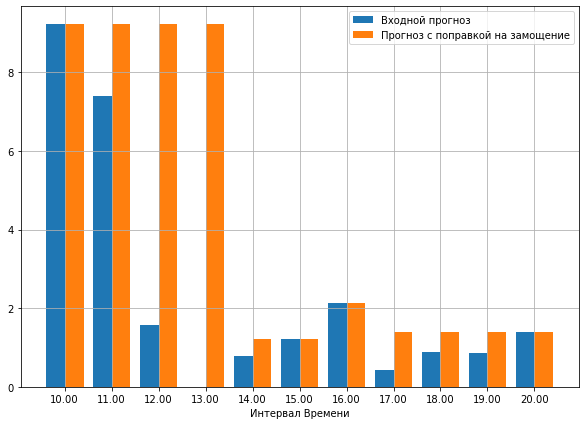

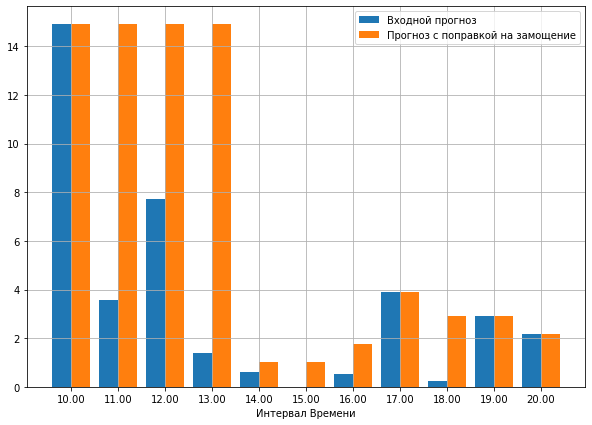

In [157]:
A = np.array(preds['partners'])
nums = [0,11,22,33,44,55,66]
my_data = A.astype(float)
for i in range(0,6):
    A = np.array(preds['partners'])
    A = A[nums[i]:nums[i+1]]
    my_data = A.astype(float)
    plot_minimized_hours(my_data)

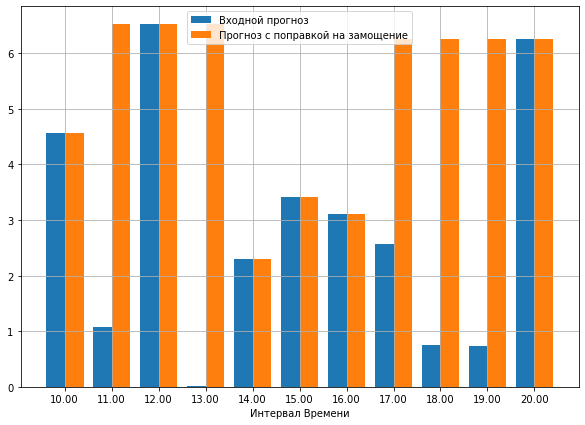

In [141]:
from scipy.optimize import linprog
import numpy as np
def plot_minimized_hours(my_data):
    # cminimizes spare hours
    A = np.zeros((11,30),dtype = int)
    j=0
    for length in range(4,9):
        for i in range(12-length):
            A[i:(i+length),j] = -1
            j += 1
    B = -1*A
    A = A.tolist()
    c = [1 for i in range(30)]
    #h = [-122, -117,- 89,-23,-28,-31,-56,-98,-112,-110]
    # h = [-1,-5,-3,-1,-2,-1,-3,-5,-6,-3,-1]
    h = []
    for i in range(0, len(my_data)):
        h.append(-my_data[i])
    # h = my_data
    res = linprog(c, A_ub=A, b_ub=h, method="revised simplex")
    number_cour = res.x
    my_ata_2 = np.dot(B,number_cour)

    # plots 2 histograms
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot()
    plt.xlabel("Интервал Времени")
    x=["10.00", "11.00", "12.00", "13.00", "14.00", "15.00", "16.00", "17.00", "18.00", "19.00", "20.00"]

    xpos = np.arange(len(x))     
    plt.xticks(xpos, x)
    ax.bar(xpos-0.2, my_data, width=0.4, label="Входной прогноз")
    ax.bar(xpos+0.2, my_ata_2, width=0.4, label="Прогноз с поправкой на замощение")
    plt.legend()
    ax.grid()
    

plot_minimized_hours(my_data)